In [1]:
import os
import functools

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tests.metaworld.envs.mujoco.sawyer_xyz.utils import trajectory_summary
from tests.metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise

sns.set()
%load_ext autoreload
%autoreload 2

/home/avnish/miniconda3/envs/garage_2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
def sample_trajectories_from(env, policy, act_noise_pct, iters=100):
    sampled_rewards = []
    sampled_returns = []
    sampled_first_successes = []

    for _ in range(iters):
        s = trajectory_summary(env, policy, act_noise_pct, end_on_success=False)
        sampled_rewards.append(s[1])
        sampled_returns.append(s[2])
        sampled_first_successes.append(s[3])

    sampled_rewards = np.vstack(sampled_rewards)
    sampled_returns = np.vstack(sampled_returns)
    sampled_first_successes = np.array(sampled_first_successes)

    return sampled_rewards, sampled_returns, sampled_first_successes


def plot(rewards, returns, first_successes, tag):
    first_success = min(int(first_successes.mean()), rewards.shape[1])
    first_success_rew = rewards.mean(axis=0)[first_success]
    first_success_ret = returns.mean(axis=0)[first_success]
    
    fig, ax = plt.subplots(1, 2, figsize=(6.75, 4))

    reward_df = pd.DataFrame(rewards).melt()
    ax[0] = sns.lineplot(x='variable', y='value', data=reward_df, ax=ax[0], ci=95, lw=.5)
    ax[0].set_xlabel('Time Steps')
    ax[0].set_ylabel('Reward')
    ax[0].set_title('Rewards')
    ax[0].vlines(first_success, ymin=0, ymax=first_success_rew, linestyle='--', color='green')
    ax[0].hlines(first_success_rew, xmin=0, xmax=first_success, linestyle='--', color='green')
#     ax[0].set_yscale('symlog')

    return_df = pd.DataFrame(returns).melt()
    ax[1] = sns.lineplot(x='variable', y='value', data=return_df, ax=ax[1], ci=95, lw=.5)
    ax[1].set_xlabel('Time Steps')
    ax[1].set_ylabel('Return')
    ax[1].set_title('Returns')
    ax[1].vlines(first_success, ymin=0, ymax=first_success_ret, linestyle='--', color='green')
    ax[1].hlines(first_success_ret, xmin=0, xmax=first_success, linestyle='--', color='green')
#     ax[1].set_yscale('symlog')

    plt.subplots_adjust(top=.85)
    fig.suptitle(f'{tag} (n={rewards.shape[0]})')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()
    if not os.path.exists('figures'):
        os.mkdir('figures')
    fig.savefig(f'figures/{tag}_rewards_returns.jpg')

/home/avnish/metaworld_2/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')


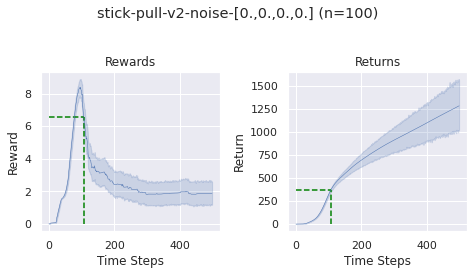

/home/avnish/miniconda3/envs/garage_2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/avnish/metaworld_2/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')


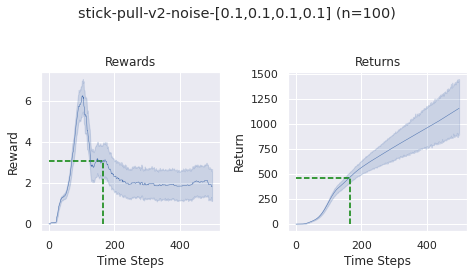

In [3]:
%reload_ext autoreload
config = [
    ['stick-pull-v2', np.zeros(4)],
    ['stick-pull-v2', np.ones(4)*0.1],
]

for env, noise in config:
    tag = env + '-noise-' + np.array2string(noise, precision=2, separator=',', suppress_small=True)

    policy = functools.reduce(lambda a,b : a if a[0] == env else b, test_cases_latest_nonoise)[1]
    env = ALL_ENVS[env]()
    env._partially_observable = False
    env._freeze_rand_vec = False
    env._set_task_called = True

    sampled_rewards, sampled_returns, sampled_first_successes = sample_trajectories_from(env, policy, noise)
    plot(sampled_rewards, sampled_returns, sampled_first_successes, tag)

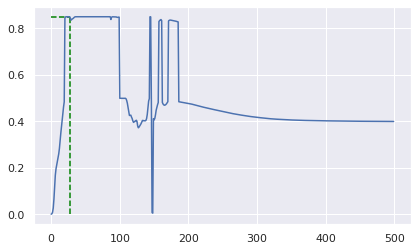

In [5]:
i = 12
first_success = sampled_first_successes[i]
first_success_reward = sampled_rewards[i][first_success]
fig, ax = plt.subplots(1, 1, figsize=(6.75, 4))
ax.plot(np.arange(len(sampled_rewards[0])), sampled_rewards[i])

ax.vlines(first_success, ymin=0, ymax=first_success_reward, linestyle='--', color='green')
ax.hlines(first_success_reward, xmin=0, xmax=first_success, linestyle='--', color='green')

In [ ]:
np.diff(sampled_rewards[i])